In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import statistics
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score

Using TensorFlow backend.


In [2]:
movie = pd.read_csv('movie_metadata.csv')

In [3]:
movie = movie.drop_duplicates()
movie.reset_index(inplace=True)
movie.shape

(4998, 29)

### DATA EXPLORATION AND CLEANING

In [4]:
# As we did the whole process in previous part(Regression modelling), we can speed up the process here.
# Although we dont need to do the encoding for categorical variables for most of the classification models.
# We will still do the encoding as algorithms such as svm and knn requires encoding

In [5]:
movie = movie[movie['title_year']>1980]
columns = ['actor_1_facebook_likes', 'cast_total_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes', 'director_facebook_likes', 'movie_facebook_likes']
for cols in columns:
    movie.loc[movie[cols]==0, cols] = np.nan
movie.dropna(subset=['gross'],inplace=True)
movie.dropna(subset=['budget'],inplace=True)
columns = ['cast_total_facebook_likes', 'director_facebook_likes', 'actor_1_facebook_likes', 'movie_facebook_likes', 'actor_2_facebook_likes', 'duration', 'facenumber_in_poster', 'num_user_for_reviews', 'actor_3_facebook_likes', 'num_critic_for_reviews', 'budget', 'gross']
for cols in columns:
    imputer = SimpleImputer(strategy = 'median')
    imputer.fit(np.asarray(movie[cols]).reshape(-1, 1))
    print(cols, '-', imputer.statistics_)
    filled = imputer.transform(np.asarray(movie[cols]).reshape(-1, 1))
    movie[cols]=filled

cast_total_facebook_likes - [3969.]
director_facebook_likes - [92.]
actor_1_facebook_likes - [1000.]
movie_facebook_likes - [10000.]
actor_2_facebook_likes - [681.]
duration - [105.]
facenumber_in_poster - [1.]
num_user_for_reviews - [200.]
actor_3_facebook_likes - [436.]
num_critic_for_reviews - [135.]
budget - [25000000.]
gross - [27669413.]


In [6]:
def preprocessing_trainingSet(data):
    data.drop(columns=['color', 'director_name', 'actor_2_name', 'actor_1_name', 'movie_title', 'plot_keywords', 'movie_imdb_link', 'language', 'actor_3_name', 'genres', 'aspect_ratio'], inplace = True)
    data['reviews'] = data['num_critic_for_reviews']+data['num_user_for_reviews']
    data.drop(columns=['num_critic_for_reviews', 'num_user_for_reviews'], inplace = True)
    data['other_actors_likes'] = data['actor_3_facebook_likes'] + data['actor_2_facebook_likes']
    data['country_UK'] = 0
    data['country_USA'] = 0
    data['country_Others'] = 0
    data.loc[(data['country']=='USA'), 'country_USA'] = 1
    data.loc[(data['country']=='UK'), 'country_UK'] = 1
    data.loc[data['country'].isin(['UK', 'USA']) == False, 'country_Others'] = 1
    data.drop(columns=['country', 'actor_3_facebook_likes', 'actor_2_facebook_likes'], inplace = True)
    data['content_PG'] = 0
    data['content_PG-13'] = 0
    data['content_R'] = 0
    data.loc[data['content_rating']=='TV-PG', 'content_rating'] = 'PG'
    data.loc[data['content_rating']=='TV-14', 'content_rating'] = 'PG-13'
    data.loc[(data['content_rating']=='PG'), 'content_PG'] = 1
    data.loc[(data['content_rating']=='PG-13'), 'content_PG-13'] = 1
    data.loc[(data['content_rating']=='R'), 'content_R'] = 1
    data.drop(columns=['content_rating'], inplace = True)
    data.drop(columns=['cast_total_facebook_likes'],inplace=True)
    data = data.rename(columns={'director_facebook_likes': 'director_likes', 
                              'actor_1_facebook_likes' : 'main_actor_likes',
                              'num_voted_users': 'votes',
                              'title_year':'year',
                              'movie_facebook_likes':'movie_likes'})
    cols = ['duration', 'director_likes', 'main_actor_likes', 'gross', 'votes', 'facenumber_in_poster', 'budget', 'year', 'movie_likes', 'country_Others', 'country_UK', 'country_USA', 'content_PG', 'content_PG-13', 'content_R', 'other_actors_likes', 'reviews', 'imdb_score']
    data = data[cols]
    #X = np.asarray(data)
    return data

In [7]:
movie = preprocessing_trainingSet(movie)
movie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3747 entries, 0 to 4997
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   duration              3747 non-null   float64
 1   director_likes        3747 non-null   float64
 2   main_actor_likes      3747 non-null   float64
 3   gross                 3747 non-null   float64
 4   votes                 3747 non-null   int64  
 5   facenumber_in_poster  3747 non-null   float64
 6   budget                3747 non-null   float64
 7   year                  3747 non-null   float64
 8   movie_likes           3747 non-null   float64
 9   country_Others        3747 non-null   int64  
 10  country_UK            3747 non-null   int64  
 11  country_USA           3747 non-null   int64  
 12  content_PG            3747 non-null   int64  
 13  content_PG-13         3747 non-null   int64  
 14  content_R             3747 non-null   int64  
 15  other_actors_likes   

In [8]:
# Defining Categories of IMDB Score
movie.loc[(movie['imdb_score']>0) & (movie['imdb_score']<3), 'imdb_category'] = 'Flop Movie'
movie.loc[(movie['imdb_score']>=3) & (movie['imdb_score']<6), 'imdb_category'] = 'Average Movie'
movie.loc[(movie['imdb_score']>=6) & (movie['imdb_score']<10), 'imdb_category'] = 'Hit Movie'
movie.drop(columns = ['imdb_score'], inplace = True)
movie['imdb_category'].value_counts()

Hit Movie        2683
Average Movie    1039
Flop Movie         25
Name: imdb_category, dtype: int64

### TRAINING AND EVALUATING MODELS

In [9]:
data_split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.3, random_state = 42)
for train_index, test_index in data_split.split(movie, movie['imdb_category']):
    movie_train = movie.iloc[train_index]
    movie_test = movie.iloc[test_index]
print(len(movie_train), 'Train data, ', len(movie_test), 'Test data.')

2622 Train data,  1125 Test data.


In [10]:
movie_train.reset_index(inplace = True)
movie_train.drop(columns=['index'], inplace = True)
movie_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2622 entries, 0 to 2621
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   duration              2622 non-null   float64
 1   director_likes        2622 non-null   float64
 2   main_actor_likes      2622 non-null   float64
 3   gross                 2622 non-null   float64
 4   votes                 2622 non-null   int64  
 5   facenumber_in_poster  2622 non-null   float64
 6   budget                2622 non-null   float64
 7   year                  2622 non-null   float64
 8   movie_likes           2622 non-null   float64
 9   country_Others        2622 non-null   int64  
 10  country_UK            2622 non-null   int64  
 11  country_USA           2622 non-null   int64  
 12  content_PG            2622 non-null   int64  
 13  content_PG-13         2622 non-null   int64  
 14  content_R             2622 non-null   int64  
 15  other_actors_likes   

c:\users\vivek\.conda\envs\machine_learning\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
movie_test.reset_index(inplace = True)
movie_test.drop(columns=['index'], inplace = True)
movie_test.info()
#Now we will not use our movie_test till our model is finalized.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   duration              1125 non-null   float64
 1   director_likes        1125 non-null   float64
 2   main_actor_likes      1125 non-null   float64
 3   gross                 1125 non-null   float64
 4   votes                 1125 non-null   int64  
 5   facenumber_in_poster  1125 non-null   float64
 6   budget                1125 non-null   float64
 7   year                  1125 non-null   float64
 8   movie_likes           1125 non-null   float64
 9   country_Others        1125 non-null   int64  
 10  country_UK            1125 non-null   int64  
 11  country_USA           1125 non-null   int64  
 12  content_PG            1125 non-null   int64  
 13  content_PG-13         1125 non-null   int64  
 14  content_R             1125 non-null   int64  
 15  other_actors_likes   

In [12]:
y = np.asarray(movie_train['imdb_category'].copy()).reshape(-1,1)
X = np.asarray(movie_train.drop(columns=['imdb_category']).copy())
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [13]:
model_comparision = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

#### SGD Classifier without Over-Sampling

In [14]:
sgd_clf = SGDClassifier(random_state = 42)
train_predicted = cross_val_predict(sgd_clf, X, y.reshape(1,-1)[0], cv=3)
conf_mx = confusion_matrix(y, train_predicted)

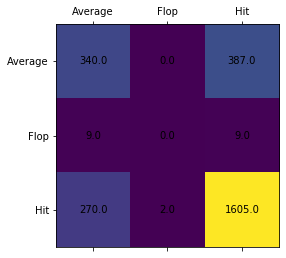

In [15]:
plt.matshow(conf_mx)
alpha = ['Average', 'Flop', 'Hit']
alpha_i= list(range(len(alpha)))
plt.xticks(alpha_i, alpha)
plt.yticks(alpha_i, alpha)
for (i, j), z in np.ndenumerate(conf_mx):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

In [16]:
def get_accuracy(mat):
    acc = 0
    tot = 0
    for i in range(3):
        for j in range(3):
            tot += mat[i][j]
            if i == j:
                acc += mat[i][j]
    return acc/tot

In [17]:
accuracy = get_accuracy(conf_mx)
precision = precision_score(y, train_predicted, average="macro")
recall = recall_score(y, train_predicted, average="macro")
f1 = f1_score(y, train_predicted, average="macro")
model_comparision = model_comparision.append({'Model':'SGD W/O Oversampling', 'Accuracy':accuracy, 'Precision':precision, 'Recall':recall, 'F1':f1}, ignore_index=True)

In [18]:
movie_train['imdb_category'].value_counts()
# We have to oversample the imbalanced dataset to get some better results

Hit Movie        1877
Average Movie     727
Flop Movie         18
Name: imdb_category, dtype: int64

#### OVER-SAMPLING ON IMBALANCED DATASET

In [19]:
smote = SMOTE('minority')
X_os, y_os = smote.fit_sample(X, y)
X_os, y_os = smote.fit_sample(X_os, y_os)
# We have to do over-sampling twice as there are two minority classes.

#### SGD Classifier

In [20]:
train_predicted = cross_val_predict(sgd_clf, X_os, y_os, cv=3)
conf_mx = confusion_matrix(y_os, train_predicted)

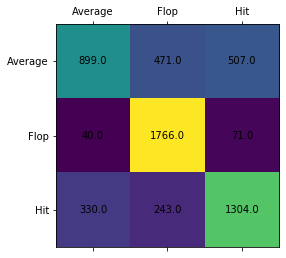

In [21]:
plt.matshow(conf_mx)
alpha = ['Average', 'Flop', 'Hit']
alpha_i= list(range(len(alpha)))
plt.xticks(alpha_i, alpha)
plt.yticks(alpha_i, alpha)
for (i, j), z in np.ndenumerate(conf_mx):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

In [22]:
accuracy = get_accuracy(conf_mx)
precision = precision_score(y_os, train_predicted, average="macro")
recall = recall_score(y_os, train_predicted, average="macro")
f1 = f1_score(y_os, train_predicted, average="macro")
model_comparision = model_comparision.append({'Model':'SGD', 'Accuracy':accuracy, 'Precision':precision, 'Recall':recall, 'F1':f1}, ignore_index=True)

#### Random Forest

In [23]:
forest_clf = RandomForestClassifier(random_state = 42)
train_predicted = cross_val_predict(forest_clf, X_os, y_os, cv=3)
conf_mx = confusion_matrix(y_os, train_predicted)

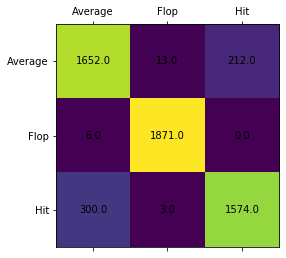

In [24]:
plt.matshow(conf_mx)
alpha = ['Average', 'Flop', 'Hit']
alpha_i= list(range(len(alpha)))
plt.xticks(alpha_i, alpha)
plt.yticks(alpha_i, alpha)
for (i, j), z in np.ndenumerate(conf_mx):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

In [25]:
accuracy = get_accuracy(conf_mx)
precision = precision_score(y_os, train_predicted, average="macro")
recall = recall_score(y_os, train_predicted, average="macro")
f1 = f1_score(y_os, train_predicted, average="macro")
model_comparision = model_comparision.append({'Model':'Random Forest', 'Accuracy':accuracy, 'Precision':precision, 'Recall':recall, 'F1':f1}, ignore_index=True)

#### SVM Classifier - Support Vector Classification

In [26]:
svm_clf = svm.SVC(random_state = 42)
train_predicted = cross_val_predict(svm_clf, X_os, y_os, cv=3)
conf_mx = confusion_matrix(y_os, train_predicted)

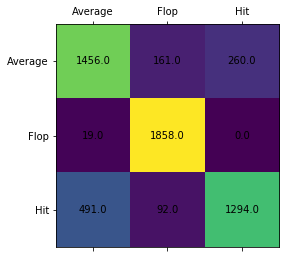

In [27]:
plt.matshow(conf_mx)
alpha = ['Average', 'Flop', 'Hit']
alpha_i= list(range(len(alpha)))
plt.xticks(alpha_i, alpha)
plt.yticks(alpha_i, alpha)
for (i, j), z in np.ndenumerate(conf_mx):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

In [28]:
accuracy = get_accuracy(conf_mx)
precision = precision_score(y_os, train_predicted, average="macro")
recall = recall_score(y_os, train_predicted, average="macro")
f1 = f1_score(y_os, train_predicted, average="macro")
model_comparision = model_comparision.append({'Model':'SVM (SVC)', 'Accuracy':accuracy, 'Precision':precision, 'Recall':recall, 'F1':f1}, ignore_index=True)

In [29]:
svm_clf = svm.LinearSVC(random_state = 42, max_iter = 10000)
train_predicted = cross_val_predict(svm_clf, X_os, y_os, cv=3)
conf_mx = confusion_matrix(y_os, train_predicted)

c:\users\vivek\.conda\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\vivek\.conda\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\vivek\.conda\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


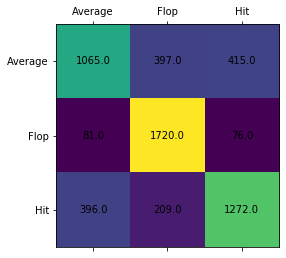

In [30]:
plt.matshow(conf_mx)
alpha = ['Average', 'Flop', 'Hit']
alpha_i= list(range(len(alpha)))
plt.xticks(alpha_i, alpha)
plt.yticks(alpha_i, alpha)
for (i, j), z in np.ndenumerate(conf_mx):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

In [31]:
accuracy = get_accuracy(conf_mx)
precision = precision_score(y_os, train_predicted, average="macro")
recall = recall_score(y_os, train_predicted, average="macro")
f1 = f1_score(y_os, train_predicted, average="macro")
model_comparision = model_comparision.append({'Model':'SVM (Linear SVC)', 'Accuracy':accuracy, 'Precision':precision, 'Recall':recall, 'F1':f1}, ignore_index=True)

#### K-NN Algorithm

In [32]:
# Creating odd list K for KNN
neighbors = list(range(1,50,2))
# empty list that will hold cv scores
cv_scores = [ ]
#perform 10-fold cross-validation
for K in neighbors:
    knn = KNeighborsClassifier(n_neighbors = K)
    scores = cross_val_score(knn,X_os,y_os,cv = 10,scoring =
    "accuracy")
    cv_scores.append(scores.mean())

In [33]:
# Changing to mse classification error
mse = [1-x for x in cv_scores]
# determing best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal no. of neighbors is {}".format(optimal_k))

The optimal no. of neighbors is 1


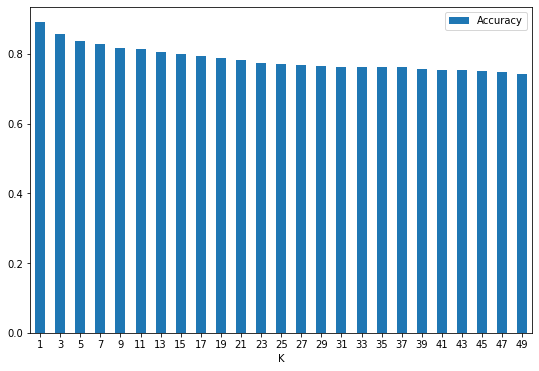

In [34]:
def plot_accuracy(knn_list_scores):
    pd.DataFrame({"K":[i for i in range(1,50,2)], "Accuracy":knn_list_scores}).set_index("K").plot.bar(figsize= (9,6),rot=0)
    plt.show()
plot_accuracy(cv_scores)

In [35]:
knn_clf = KNeighborsClassifier(n_neighbors=1)
train_predicted = cross_val_predict(knn_clf, X_os, y_os, cv=3)
conf_mx = confusion_matrix(y_os, train_predicted)

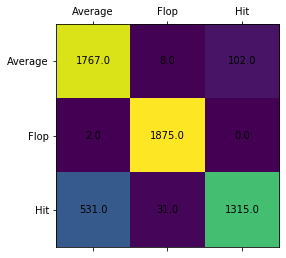

In [36]:
plt.matshow(conf_mx)
alpha = ['Average', 'Flop', 'Hit']
alpha_i= list(range(len(alpha)))
plt.xticks(alpha_i, alpha)
plt.yticks(alpha_i, alpha)
for (i, j), z in np.ndenumerate(conf_mx):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

In [37]:
accuracy = get_accuracy(conf_mx)
precision = precision_score(y_os, train_predicted, average="macro")
recall = recall_score(y_os, train_predicted, average="macro")
f1 = f1_score(y_os, train_predicted, average="macro")
model_comparision = model_comparision.append({'Model':'KNN', 'Accuracy':accuracy, 'Precision':precision, 'Recall':recall, 'F1':f1}, ignore_index=True)

In [38]:
model_comparision.sort_values(by=['F1'], inplace = True)
model_comparision

,Model,Accuracy,Precision,Recall,F1
0,SGD W/O Oversampling,0.741800,0.450457,0.440921,0.444316
1,SGD,0.704848,0.704470,0.704848,0.691990
4,SVM (Linear SVC),0.720476,0.717209,0.720476,0.713451
3,SVM (SVC),0.818327,0.817810,0.818327,0.814612
5,KNN,0.880305,0.891967,0.880305,0.877889
2,Random Forest,0.905168,0.905513,0.905168,0.905033


### EVALUATION ON TEST DATA

In [39]:
# Looking at the above table we should choose Random Forest as our final model.
forest_clf.fit(X_os, y_os)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [40]:
y = np.asarray(movie_test['imdb_category'].copy()).reshape(-1,1)
X = np.asarray(movie_test.drop(columns=['imdb_category']).copy())
X = scaler.transform(X)

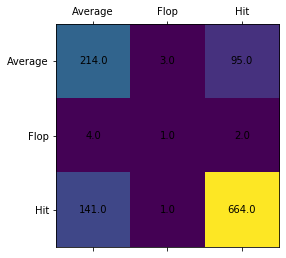

In [41]:
predict = forest_clf.predict(X)
conf_mx = confusion_matrix(y, predict)
plt.matshow(conf_mx)
alpha = ['Average', 'Flop', 'Hit']
alpha_i= list(range(len(alpha)))
plt.xticks(alpha_i, alpha)
plt.yticks(alpha_i, alpha)
for (i, j), z in np.ndenumerate(conf_mx):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

In [42]:
print('Accuarcy -', get_accuracy(conf_mx))
print('Precision -', precision_score(y, predict, average="macro"))
print('recall -', recall_score(y, predict, average="macro"))
print('f1 -', f1_score(y, predict, average="macro"))

Accuarcy - 0.7813333333333333
Precision - 0.5562121384046063
recall - 0.5508586395683169
f1 - 0.5506666252426659
